- 解决过拟合问题的常用方法：权重衰减

## 3.12.1 方法
- 权重衰减等价于$L_2$范数正则化(regularization)。正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段。
- $L_2$范数正则化在模型原损失函数基础上添加$L_2$范数惩罚项，从而的到训练所需要最小化的函数。$L_2$函数惩罚项指的是模型权重参数每个元素的平方和与一个正常数的乘积。
- 设线性回归损失函数为
    $$
        l(w_1,w_2,b) = \frac{1}{n}\sum_{i=1}^n\frac{1}{2}(x_1^{(i)}w_1 + x_2^{(i)}w_2 + b - y^{(i)})^2
    $$
    
- 带有$L_2$范数惩罚项的新损失函数为
    $$
        l(w_1,w_2,b) + \frac{\lambda}{2n}\parallel{w}\parallel^2
    $$
- 有了$L_2$范数惩罚项后，在小批量随机梯度下降中，我们将$w_1$和$w_2$的迭代方式更改为

    $$
    w_1 \leftarrow (1 - \frac{\eta\lambda}{|\beta|})w_1 - \frac{\eta}{|\beta|}\sum_{i\in\beta}x_1^{(i)}(x_1^{(i)}w_1 + x_2^{(i)}w_2 + b - y^{(i)}), \\
    w_2 \leftarrow (1 - \frac{\eta\lambda}{|\beta|})w_2 - \frac{\eta}{|\beta|}\sum_{i\in\beta}x_2^{(i)}(x_1^{(i)}w_1 + x_2^{(i)}w_2 + b - y^{(i)}).
    $$
- 在这里就解释了$L_2$范数正则化为什么又叫权重衰减（权重首先先自乘小于1的数）了

## 3.12.2 高维线性回归实验
- 我们使用如下的线性函数来生成该样本的标签
$$
    y = 0.05 + \sum_{i=1}^p0.01x_i + \epsilon
$$
    其中噪声项\epsilon服从均值为0,标准差为0.01的正态分布。我们设维度p=200;
    同时，我们特意吧训练数据集的样本数设低，如20
  

In [10]:
%matplotlib inline
import sys
sys.path.append('../')
import d2lzh as d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = nd.ones((num_inputs, 1)) * 0.01, 0.05

features = nd.random.normal(shape=(n_train + n_test, num_inputs))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

## 3.12.3 从零开始实现


### 初始化模型参数

In [11]:
def init_params():
    w = nd.random.normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    w.attach_grad()
    b.attach_grad()
    return [w, b]

### 定义$L_2$范数惩罚项

In [12]:
def l2_penalty(w):
    return (w**2).sum() / 2

### 定义训练和测试

In [14]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = d2l.linreg, d2l.squared_loss
train_iter = gdata.DataLoader(gdata.ArrayDataset(
    train_features, train_labels
    ), batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                # 添加L2范数惩罚项
                l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b), test_labels).mean().asscalar())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().asscalar())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().asscalar())

### 观察过拟合

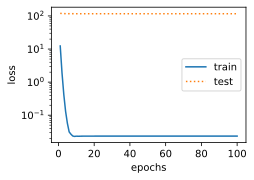

L2 norm of w: 13.752045


In [16]:
fit_and_plot(lambd=0)

### 使用权重衰减

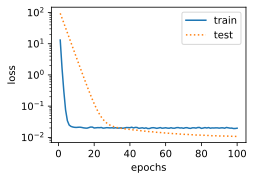

L2 norm of w: 0.040942863


In [17]:
fit_and_plot(lambd=3)

### 3.12.4 简洁实现

In [18]:
def fit_and_plot_gluon(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    # 对权重参数衰减。权重名称一般是以weight结尾的
    trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd', {'learning_rate': lr, 'wd': wd})
    
    # 不对偏差参数衰减。偏差名称一般是以bias结尾
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd', {'learning_rate': lr})
    
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        train_ls.append(loss(net(train_features), train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features), test_labels).mean().asscalar())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net[0].weight.data().norm().asscalar())

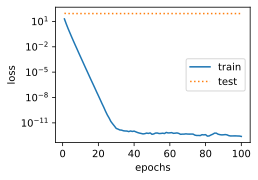

L2 norm of w: 13.283741


In [20]:
fit_and_plot_gluon(0)

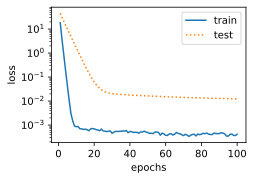

L2 norm of w: 0.03849948


In [21]:
fit_and_plot_gluon(3)

### 小结
- 正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段
- 权重衰减等价于$L_2$范数正则化，通常会使学到的权重参数的元素较接近0
- 权重衰减可以通过Gluon的wd超参数来指定
- 可以定义多个Trainer实例对不同的模型参数使用不同的迭代方法

### 练习
- 回顾一下训练误差和泛化误差的关系。除了权重衰减、增大训练量以及使用复杂度合适的模型，你还能想到哪些办法来应对过拟合？
    - dropout丢弃法